**Import Libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

#Neural Network
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Naive bayes
from sklearn.naive_bayes import GaussianNB 

#Stacking
from mlxtend.classifier import StackingClassifier

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

**Load Data**

In [2]:
df = pd.read_csv('data/data.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


# 1. **Scaling and Fitting**

In [3]:
# Scaling Age
scaler = MinMaxScaler()
df['Age'] = scaler.fit_transform(df[['Age']])
df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


**Splitting Dataset**

In [4]:
# define X and y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = df[feature_cols]
y = df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

**Features Importance**

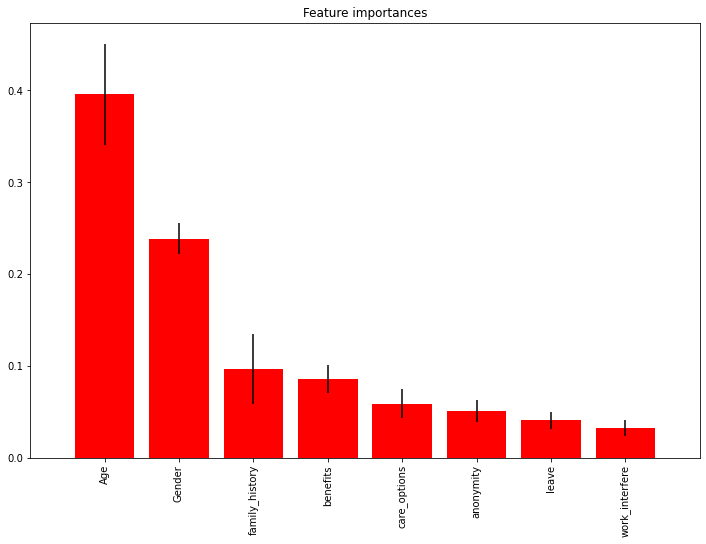

In [5]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])      
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

# 2. **Tuning**

**Evaluating a Classification Model.**

This function will evalue:

* **Classification accuracy:** percentage of correct predictions
* **Null accuracy:** accuracy that could be achieved by always predicting the most frequent class
Percentage of ones
Percentage of zeros
* **Confusion matrix:** Table that describes the performance of a classification model

**True Positives (TP):** we correctly predicted that they do have diabetes
**True Negatives (TN):** we correctly predicted that they don't have diabetes
**False Positives (FP):** we incorrectly predicted that they do have diabetes (a "Type I error")
  Falsely predict positive
* **False Negatives (FN):** we incorrectly predicted that they don't have diabetes (a "Type II error")
  Falsely predict negative
False Positive Rate

* **Precision of Positive value**
* **AUC:** is the percentage of the ROC plot that is underneath the curve
  .90-1 = excellent (A)
  .80-.90 = good (B)
  .70-.80 = fair (C)
  .60-.70 = poor (D)
  .50-.60 = fail (F)
And some others values for tuning processes. More information: 
[http://www.ritchieng.com/machine-learning-evaluate-classification-model/]

In [6]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    #Classification accuracy: percentage of correct predictions
    # calculate accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    
    #Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # examine the class distribution of the testing set (using a Pandas Series method)
    print('Null accuracy:\n', y_test.value_counts())
    
    # calculate the percentage of ones
    print('Percentage of ones:', y_test.mean())
    
    # calculate the percentage of zeros
    print('Percentage of zeros:',1 - y_test.mean())
    
    #Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])
    
    #Conclusion:
    #Classification accuracy is the easiest classification metric to understand
    #But, it does not tell you the underlying distribution of response values
    #And, it does not tell you what "types" of errors your classifier is making
    
    #Confusion matrix
    # save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    #Metrics computed from a confusion matrix
    #Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    
    #Classification Error: Overall, how often is the classifier incorrect?
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)
    
    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    
    
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    
    # calculate cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    
    ##########################################
    #Adjusting the classification threshold
    ##########################################
    # print the first 10 predicted responses
    # 1D array (vector) of binary values (0, 1)
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])

    # print the first 10 predicted probabilities of class membership
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])

    # print the first 10 predicted probabilities for class 1
    model.predict_proba(X_test)[0:10, 1]
    
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        # histogram of predicted probabilities
        # adjust the font size 
        plt.rcParams['font.size'] = 12
        # 8 bins
        plt.hist(y_pred_prob, bins=8)
        
        # x-axis limit from 0 to 1
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')
    
    
    # predict treatment if the predicted probability is greater than 0.3
    # it will return 1 for all values above 0.3 and 0 otherwise
    # results are 2D so we slice out the first column
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    # print the first 10 predicted probabilities
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])
    
    ##########################################
    #ROC Curves and Area Under the Curve (AUC)
    ##########################################
    
    #Question: Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?
    #Answer: Plot the ROC curve!
    
    
    #AUC is the percentage of the ROC plot that is underneath the curve
    #Higher value = better classifier
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    # we pass y_test and y_pred_prob
    # we do not use y_pred_class, because it will give incorrect results without generating an error
    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    # define a function that accepts a threshold and prints sensitivity and specificity
    def evaluate_threshold(threshold):
        #Sensitivity: When the actual value is positive, how often is the prediction correct?
        #Specificity: When the actual value is negative, how often is the prediction correct?print('Sensitivity for ' + str(threshold) + ' :', tpr[thresholds > threshold][-1])
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])

    # One way of setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)
    
    
    
    return accuracy

**Tuning with cross validation score**

In [7]:
##########################################
# Tuning with cross validation score
##########################################
def tuningCV(knn):
    
    # search for an optimal value of K for KNN
    k_range = list(range(1, 31))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())
    print(k_scores)
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()

**Tuning with GridSearchCV**

In [8]:
def tuningGridSerach(knn):
    #More efficient parameter tuning using GridSearchCV
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    print(k_range)
    
    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range)
    print(param_grid)
    
    # instantiate the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

    # fit the grid with data
    grid.fit(X, y)
    
    # view the complete results (list of named tuples)
    grid.grid_scores_
    
    # examine the first tuple
    print(grid.grid_scores_[0].parameters)
    print(grid.grid_scores_[0].cv_validation_scores)
    print(grid.grid_scores_[0].mean_validation_score)
    
    # create a list of the mean scores only
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    print(grid_mean_scores)
    
    # plot the results
    plt.plot(k_range, grid_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    
    # examine the best model
    print('GridSearch best score', grid.best_score_)
    print('GridSearch best params', grid.best_params_)
    print('GridSearch best estimator', grid.best_estimator_)

**Tuning with RandomizedSearchCV**

In [9]:
def tuningRandomizedSearchCV(model, param_dist):
    #Searching multiple parameters simultaneously
    # n_iter controls the number of searches
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)
    rand.score
    
    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    print('Rand. Best Params: ', rand.best_params_)
    
    # run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print(best_scores)

**Tuning with searching multiple parameters simultaneously**

In [10]:
def tuningMultParam(knn):
    
    #Searching multiple parameters simultaneously
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
        
    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range, weights=weight_options)
    print(param_grid) 
    
    # instantiate and fit the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y) 
    
    # view the complete results
    print(grid.grid_scores_)
    
    # examine the best model
    print('Multiparam. Best Score: ', grid.best_score_)
    print('Multiparam. Best Params: ', grid.best_params_)

# 3. **Evaluating models**

**Logistic Regression**

In [11]:
def logisticRegression():
    # train a logistic regression model on the training set
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = logreg.predict(X_test)
    
    print('########### Logistic Regression ###############')
    
    accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)
    
    #Data for final graph
    methodDict['Log. Regres.'] = accuracy_score * 100

########### Logistic Regression ###############
Accuracy: 0.7857142857142857
Null accuracy:
 1    132
0    120
Name: treatment, dtype: int64
Percentage of ones: 0.5238095238095238
Percentage of zeros: 0.47619047619047616
True: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0]
Pred: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0]


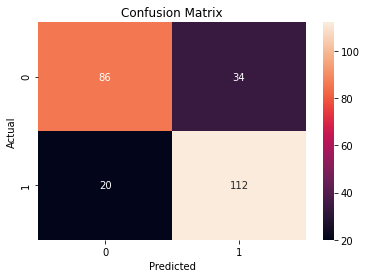

Classification Accuracy: 0.7857142857142857
Classification Error: 0.2142857142857143
False Positive Rate: 0.2833333333333333
Precision: 0.7671232876712328
AUC Score: 0.7825757575757576
Cross-validated AUC: 0.8753623882722146
First 10 predicted responses:
 [0 0 0 0 0 1 1 0 1 0]
First 10 predicted probabilities of class members:
 [[0.92915533 0.07084467]
 [0.71800652 0.28199348]
 [0.95782628 0.04217372]
 [0.96366457 0.03633543]
 [0.93058343 0.06941657]
 [0.15570404 0.84429596]
 [0.12177835 0.87822165]
 [0.83360769 0.16639231]
 [0.29066547 0.70933453]
 [0.95726744 0.04273256]]


TypeError: binarize() takes 1 positional argument but 2 were given

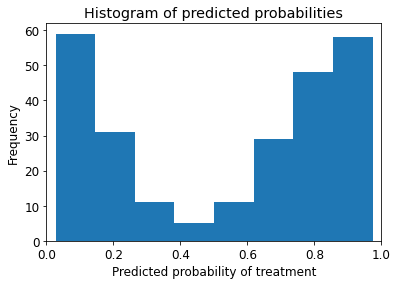

In [12]:
logisticRegression()

**KNeighbors Classifier**

In [13]:
def Knn():
    # Calculating the best parameters
    knn = KNeighborsClassifier(n_neighbors=5)
    
    # From https://github.com/justmarkham/scikit-learn-videos/blob/master/08_grid_search.ipynb
    #tuningCV(knn)
    #tuningGridSerach(knn)
    #tuningMultParam(knn)
    
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
    
    # specify "parameter distributions" rather than a "parameter grid"
    param_dist = dict(n_neighbors=k_range, weights=weight_options)
    tuningRandomizedSearchCV(knn, param_dist)
    
    # train a KNeighborsClassifier model on the training set
    knn = KNeighborsClassifier(n_neighbors=27, weights='uniform')
    knn.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = knn.predict(X_test)
    
    print('########### KNeighborsClassifier ###############')
    
    accuracy_score = evalClassModel(knn, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['KNN'] = accuracy_score * 100

Rand. Best Score:  0.8217714285714285
Rand. Best Params:  {'weights': 'uniform', 'n_neighbors': 27}
[0.818, 0.818, 0.822, 0.822, 0.821, 0.818, 0.816, 0.815, 0.815, 0.811, 0.818, 0.822, 0.822, 0.822, 0.822, 0.822, 0.814, 0.821, 0.816, 0.817]
########### KNeighborsClassifier ###############
Accuracy: 0.7896825396825397
Null accuracy:
 1    132
0    120
Name: treatment, dtype: int64
Percentage of ones: 0.5238095238095238
Percentage of zeros: 0.47619047619047616
True: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0]
Pred: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0]


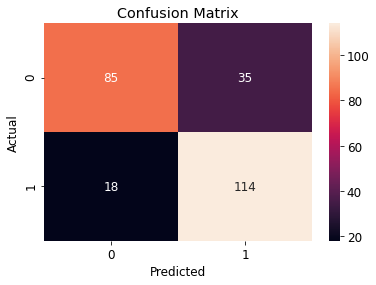

Classification Accuracy: 0.7896825396825397
Classification Error: 0.21031746031746035
False Positive Rate: 0.2916666666666667
Precision: 0.7651006711409396
AUC Score: 0.7859848484848485
Cross-validated AUC: 0.878889648937532
First 10 predicted responses:
 [0 0 0 0 0 1 1 0 1 0]
First 10 predicted probabilities of class members:
 [[0.88888889 0.11111111]
 [0.77777778 0.22222222]
 [1.         0.        ]
 [1.         0.        ]
 [0.88888889 0.11111111]
 [0.37037037 0.62962963]
 [0.22222222 0.77777778]
 [0.88888889 0.11111111]
 [0.14814815 0.85185185]
 [1.         0.        ]]


TypeError: binarize() takes 1 positional argument but 2 were given

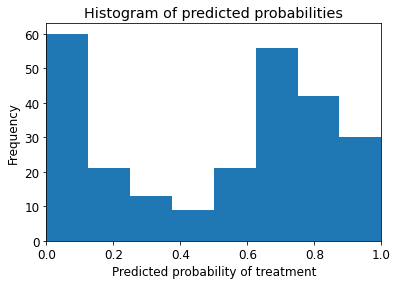

In [14]:
Knn()

**Decision Tree Classifier**

In [15]:
def treeClassifier():
    # Calculating the best parameters
    tree = DecisionTreeClassifier()
    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(tree, param_dist)
    
    # train a decision tree model on the training set
    tree = DecisionTreeClassifier(max_depth=3, min_samples_split=8, max_features=6, criterion='entropy', min_samples_leaf=7)
    tree.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = tree.predict(X_test)
    
    print('########### Tree classifier ###############')
    
    accuracy_score = evalClassModel(tree, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Tree clas.'] = accuracy_score * 100

Rand. Best Score:  0.8305206349206349
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 6, 'min_samples_split': 4}
[0.831, 0.831, 0.831, 0.791, 0.831, 0.831, 0.829, 0.826, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.828, 0.801, 0.831, 0.814]
########### Tree classifier ###############
Accuracy: 0.8015873015873016
Null accuracy:
 1    132
0    120
Name: treatment, dtype: int64
Percentage of ones: 0.5238095238095238
Percentage of zeros: 0.47619047619047616
True: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0]
Pred: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0]


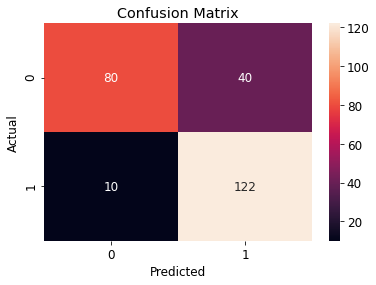

Classification Accuracy: 0.8015873015873016
Classification Error: 0.19841269841269837
False Positive Rate: 0.3333333333333333
Precision: 0.7530864197530864
AUC Score: 0.7954545454545456
Cross-validated AUC: 0.8796692670870618
First 10 predicted responses:
 [0 0 0 0 0 1 1 0 1 0]
First 10 predicted probabilities of class members:
 [[0.91428571 0.08571429]
 [0.91428571 0.08571429]
 [0.98333333 0.01666667]
 [0.98333333 0.01666667]
 [0.91428571 0.08571429]
 [0.18232044 0.81767956]
 [0.08955224 0.91044776]
 [0.91428571 0.08571429]
 [0.39690722 0.60309278]
 [0.98333333 0.01666667]]


TypeError: binarize() takes 1 positional argument but 2 were given

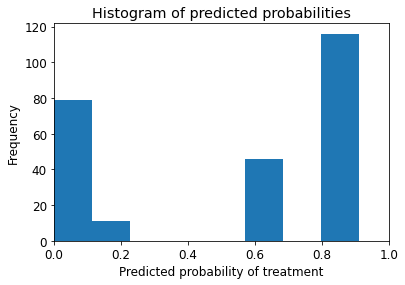

In [16]:
treeClassifier()

**Random Forest**

In [17]:
def randomForest():
    # Calculating the best parameters
    forest = RandomForestClassifier(n_estimators = 20)

    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(forest, param_dist)
    
    # Building and fitting my_forest
    forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 1)
    my_forest = forest.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = my_forest.predict(X_test)
    
    print('########### Random Forests ###############')
    
    accuracy_score = evalClassModel(my_forest, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['R. Forest'] = accuracy_score * 100

Rand. Best Score:  0.8305206349206349
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 8}
[0.834, 0.831, 0.831, 0.831, 0.831, 0.834, 0.831, 0.831, 0.832, 0.831, 0.831, 0.83, 0.831, 0.833, 0.831, 0.832, 0.836, 0.831, 0.831, 0.822]
########### Random Forests ###############
Accuracy: 0.7936507936507936
Null accuracy:
 1    132
0    120
Name: treatment, dtype: int64
Percentage of ones: 0.5238095238095238
Percentage of zeros: 0.47619047619047616
True: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0]
Pred: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0]


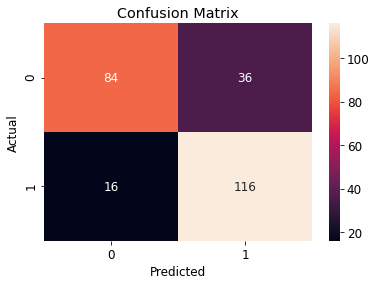

Classification Accuracy: 0.7936507936507936
Classification Error: 0.2063492063492064
False Positive Rate: 0.3
Precision: 0.7631578947368421
AUC Score: 0.7893939393939394
Cross-validated AUC: 0.8934280651104528
First 10 predicted responses:
 [0 0 0 0 0 1 1 0 1 0]
First 10 predicted probabilities of class members:
 [[0.92580565 0.07419435]
 [0.63184481 0.36815519]
 [0.95663354 0.04336646]
 [0.8981904  0.1018096 ]
 [0.8975529  0.1024471 ]
 [0.28682791 0.71317209]
 [0.26294023 0.73705977]
 [0.72913059 0.27086941]
 [0.30880101 0.69119899]
 [0.90998084 0.09001916]]


TypeError: binarize() takes 1 positional argument but 2 were given

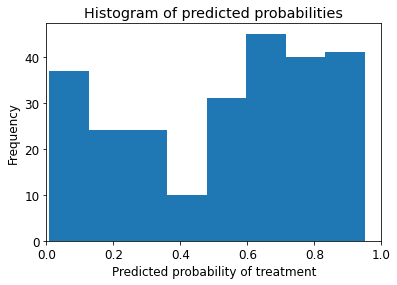

In [18]:
randomForest()

**Bagging**

In [19]:
def bagging():
    # Building and fitting 
    bag = BaggingClassifier(DecisionTreeClassifier(), max_samples=1.0, max_features=1.0, bootstrap_features=False)
    bag.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = bag.predict(X_test)
    
    print('########### Bagging ###############')
    
    accuracy_score = evalClassModel(bag, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Bagging'] = accuracy_score * 100

########### Bagging ###############
Accuracy: 0.7420634920634921
Null accuracy:
 1    132
0    120
Name: treatment, dtype: int64
Percentage of ones: 0.5238095238095238
Percentage of zeros: 0.47619047619047616
True: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0]
Pred: [0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0]


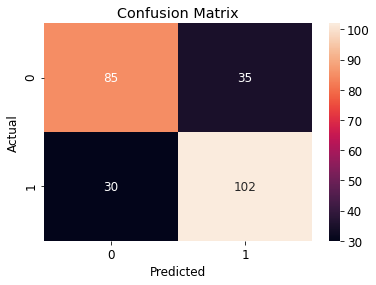

Classification Accuracy: 0.7420634920634921
Classification Error: 0.2579365079365079
False Positive Rate: 0.2916666666666667
Precision: 0.7445255474452555
AUC Score: 0.740530303030303
Cross-validated AUC: 0.8385183064414534
First 10 predicted responses:
 [0 1 0 0 0 1 0 0 1 0]
First 10 predicted probabilities of class members:
 [[1.    0.   ]
 [0.3   0.7  ]
 [1.    0.   ]
 [0.5   0.5  ]
 [0.7   0.3  ]
 [0.1   0.9  ]
 [0.5   0.5  ]
 [0.5   0.5  ]
 [0.025 0.975]
 [1.    0.   ]]


TypeError: binarize() takes 1 positional argument but 2 were given

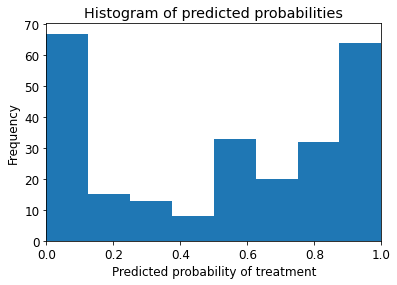

In [20]:
bagging()

**Boosting**

In [21]:
def boosting():
    # Building and fitting 
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    boost = AdaBoostClassifier(base_estimator=clf, n_estimators=500)
    boost.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = boost.predict(X_test)
    
    print('########### Boosting ###############')
    
    accuracy_score = evalClassModel(boost, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Boosting'] = accuracy_score * 100

########### Boosting ###############
Accuracy: 0.7976190476190477
Null accuracy:
 1    132
0    120
Name: treatment, dtype: int64
Percentage of ones: 0.5238095238095238
Percentage of zeros: 0.47619047619047616
True: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0]
Pred: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0]


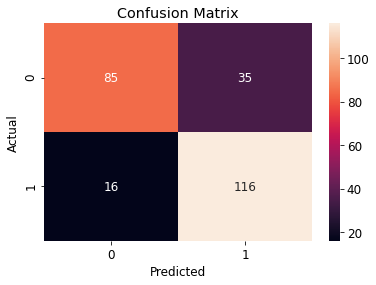

Classification Accuracy: 0.7976190476190477
Classification Error: 0.20238095238095233
False Positive Rate: 0.2916666666666667
Precision: 0.7682119205298014
AUC Score: 0.793560606060606
Cross-validated AUC: 0.8746279095195426
First 10 predicted responses:
 [0 0 0 0 0 1 1 0 1 0]
First 10 predicted probabilities of class members:
 [[0.50140184 0.49859816]
 [0.50060223 0.49939777]
 [0.50258428 0.49741572]
 [0.50235789 0.49764211]
 [0.50125225 0.49874775]
 [0.49969156 0.50030844]
 [0.4990712  0.5009288 ]
 [0.50125891 0.49874109]
 [0.4995304  0.5004696 ]
 [0.50194007 0.49805993]]


TypeError: binarize() takes 1 positional argument but 2 were given

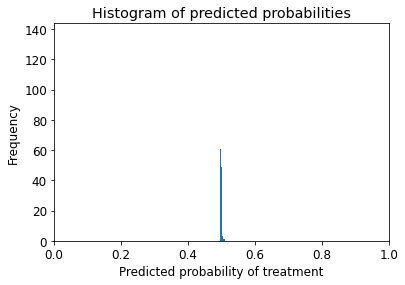

In [22]:
boosting()

**Stacking**

In [23]:
def stacking():
    # Building and fitting 
    clf1 = KNeighborsClassifier(n_neighbors=1)
    clf2 = RandomForestClassifier(random_state=1)
    clf3 = GaussianNB()
    lr = LogisticRegression()
    stack = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)
    stack.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = stack.predict(X_test)
    
    print('########### Stacking ###############')
    
    accuracy_score = evalClassModel(stack, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Stacking'] = accuracy_score * 100

########### Stacking ###############
Accuracy: 0.7619047619047619
Null accuracy:
 1    132
0    120
Name: treatment, dtype: int64
Percentage of ones: 0.5238095238095238
Percentage of zeros: 0.47619047619047616
True: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0]
Pred: [0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0]


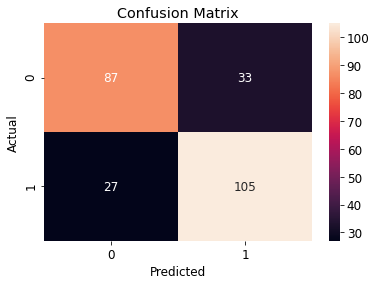

Classification Accuracy: 0.7619047619047619
Classification Error: 0.23809523809523814
False Positive Rate: 0.275
Precision: 0.7608695652173914
AUC Score: 0.7602272727272726
Cross-validated AUC: 0.8431980281658662
First 10 predicted responses:
 [0 0 0 0 0 1 1 0 1 0]
First 10 predicted probabilities of class members:
 [[0.99135328 0.00864672]
 [0.63242752 0.36757248]
 [0.99135328 0.00864672]
 [0.99135328 0.00864672]
 [0.65172128 0.34827872]
 [0.01068482 0.98931518]
 [0.39821405 0.60178595]
 [0.99135328 0.00864672]
 [0.01068482 0.98931518]
 [0.99135328 0.00864672]]


TypeError: binarize() takes 1 positional argument but 2 were given

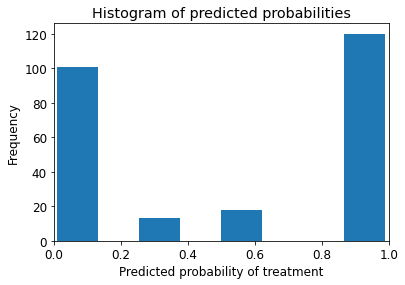

In [24]:
stacking()

# 4. **Predicting with Neural Network**

# 5. **Success Method Plot**

In [25]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    #Colors
    ax = s.plot(kind='bar') 
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([70.0, 90.0])
    plt.xlabel('Method')
    plt.ylabel('Percentage')
    plt.title('Success of methods')
     
    plt.show()

<ipython-input-25-15f8d1e79571>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(methodDict)


IndexError: index 0 is out of bounds for axis 0 with size 0

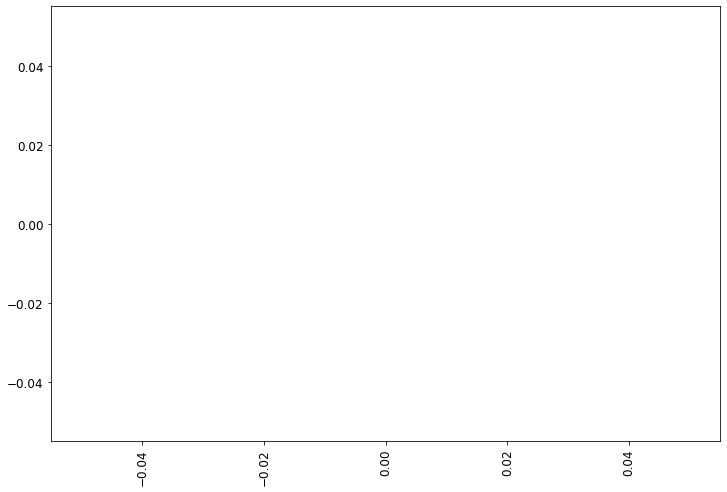

In [26]:
plotSuccess()